# Natural Gas Contract's Price Modeling #
The goal of this tool is to model the natural gas contract price for +12 months period.

#### JP Morgan Instructions : ####
1. Download the monthly natural gas price data.
2. Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
3. Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
4. Your code should take a date as input and return a price estimate.

### Setting the Libraries and preparing the data ###

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime as dt
import seaborn as sns
from scipy import stats
from scipy.stats import norm


### 1. Data Visualization ###

In [3]:
gas_df = pd.read_csv('natural_gas_market_data.csv')
gas_df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [4]:
def convert_date_format(date_str):
    try:
        return dt.strptime(date_str, '%m/%d/%y').strftime('%b %y')
    except ValueError:
        return None

str_months = []
for i in gas_df.index :
    str_months.append(convert_date_format(gas_df['Dates'][i]))
print(str_months)

['Oct 20', 'Nov 20', 'Dec 20', 'Jan 21', 'Feb 21', 'Mar 21', 'Apr 21', 'May 21', 'Jun 21', 'Jul 21', 'Aug 21', 'Sep 21', 'Oct 21', 'Nov 21', 'Dec 21', 'Jan 22', 'Feb 22', 'Mar 22', 'Apr 22', 'May 22', 'Jun 22', 'Jul 22', 'Aug 22', 'Sep 22', 'Oct 22', 'Nov 22', 'Dec 22', 'Jan 23', 'Feb 23', 'Mar 23', 'Apr 23', 'May 23', 'Jun 23', 'Jul 23', 'Aug 23', 'Sep 23', 'Oct 23', 'Nov 23', 'Dec 23', 'Jan 24', 'Feb 24', 'Mar 24', 'Apr 24', 'May 24', 'Jun 24', 'Jul 24', 'Aug 24', 'Sep 24']


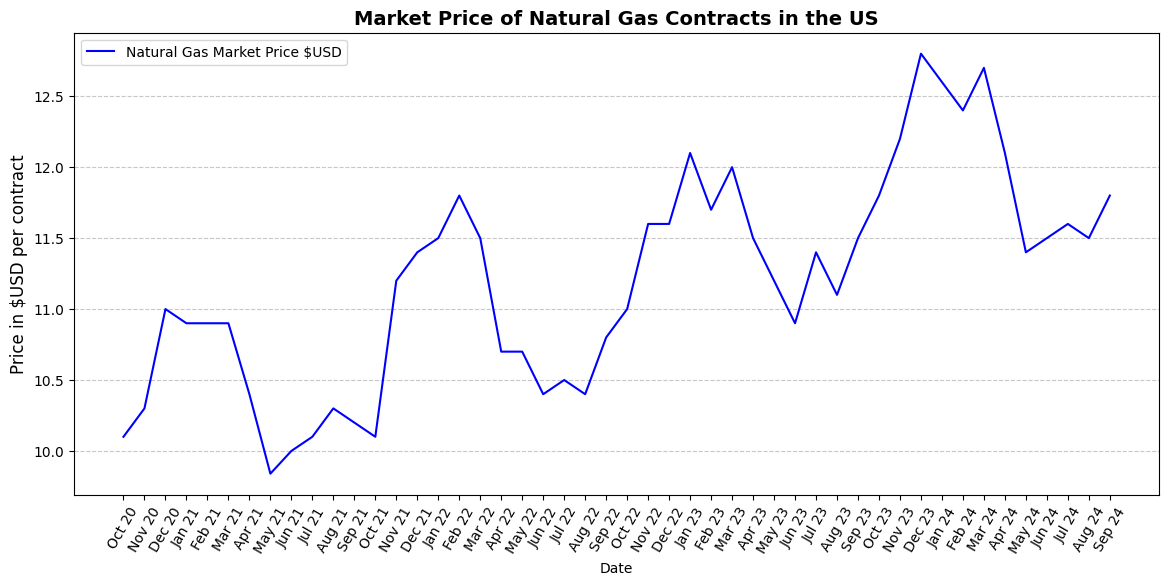

In [5]:
# Visualization of the market price of gas storage contracts
plt.figure(figsize=(14, 6))
plt.plot(gas_df['Dates'], gas_df['Prices'], color='blue', label='Natural Gas Market Price $USD')
plt.xlabel('Date')
plt.xticks(gas_df['Dates'], str_months, rotation=60, fontsize=10)
plt.ylabel('Price in $USD per contract', fontsize=12)
plt.title('Market Price of Natural Gas Contracts in the US', fontsize=14, weight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 2. Trend Analysis ###

In [6]:
gas_df.set_index('Dates', inplace=True)
print(gas_df.index)

Index(['10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21', '3/31/21',
       '4/30/21', '5/31/21', '6/30/21', '7/31/21', '8/31/21', '9/30/21',
       '10/31/21', '11/30/21', '12/31/21', '1/31/22', '2/28/22', '3/31/22',
       '4/30/22', '5/31/22', '6/30/22', '7/31/22', '8/31/22', '9/30/22',
       '10/31/22', '11/30/22', '12/31/22', '1/31/23', '2/28/23', '3/31/23',
       '4/30/23', '5/31/23', '6/30/23', '7/31/23', '8/31/23', '9/30/23',
       '10/31/23', '11/30/23', '12/31/23', '1/31/24', '2/29/24', '3/31/24',
       '4/30/24', '5/31/24', '6/30/24', '7/31/24', '8/31/24', '9/30/24'],
      dtype='object', name='Dates')


In [7]:
# Simple moving average 3 and 12 months
gas_df['SMA_3'] = gas_df.Prices.rolling(3).mean()
gas_df['SMA_12'] = gas_df.Prices.rolling(12).mean()
gas_df.head()

,Prices,SMA_3,SMA_12
Dates,,,
10/31/20,10.1,NaN,NaN
11/30/20,10.3,NaN,NaN
12/31/20,11.0,10.466667,NaN
1/31/21,10.9,10.733333,NaN
2/28/21,10.9,10.933333,NaN


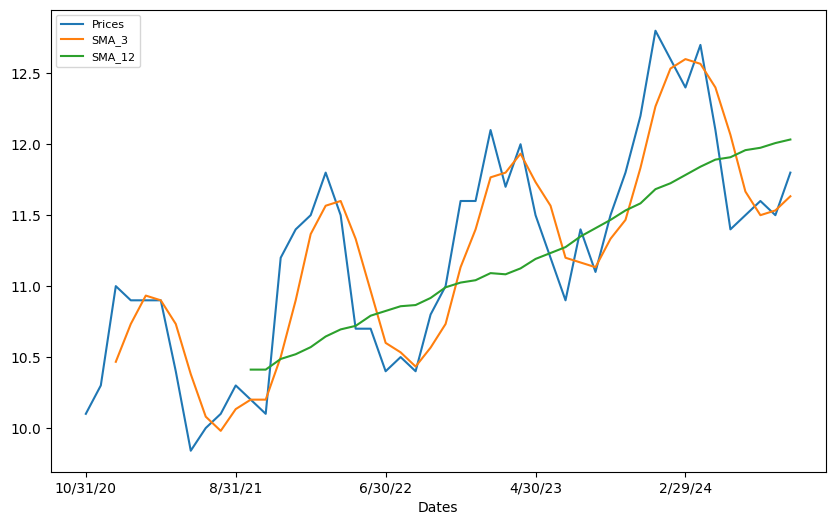

In [8]:
gas_df.loc[:,["Prices","SMA_3","SMA_12"]].plot(figsize=(10,6))
plt.legend(loc="upper left",fontsize=8)
plt.show()

In [9]:
# Treating the data as a time series
time = np.arange(1, len(gas_df) + 1)
gas_df['time'] = time
print('Orinial Data gas_df')
print(gas_df.tail())
data = gas_df[['time', 'Prices']]
print('\nNew time series data')
print(data.tail())

Orinial Data gas_df
         Prices      SMA_3     SMA_12  time
Dates                                      
5/31/24    11.4  12.066667  11.908333    44
6/30/24    11.5  11.666667  11.958333    45
7/31/24    11.6  11.500000  11.975000    46
8/31/24    11.5  11.533333  12.008333    47
9/30/24    11.8  11.633333  12.033333    48

New time series data
         time  Prices
Dates                
5/31/24    44    11.4
6/30/24    45    11.5
7/31/24    46    11.6
8/31/24    47    11.5
9/30/24    48    11.8


In [10]:
# Linear regression for annualized trends
reg = np.polyfit(data['time'], data['Prices'], deg=1)
print(f'Regression model is: y = {reg[0]:.2f}x + {reg[1]:.2f}')

Regression model is: y = 0.04x + 10.25


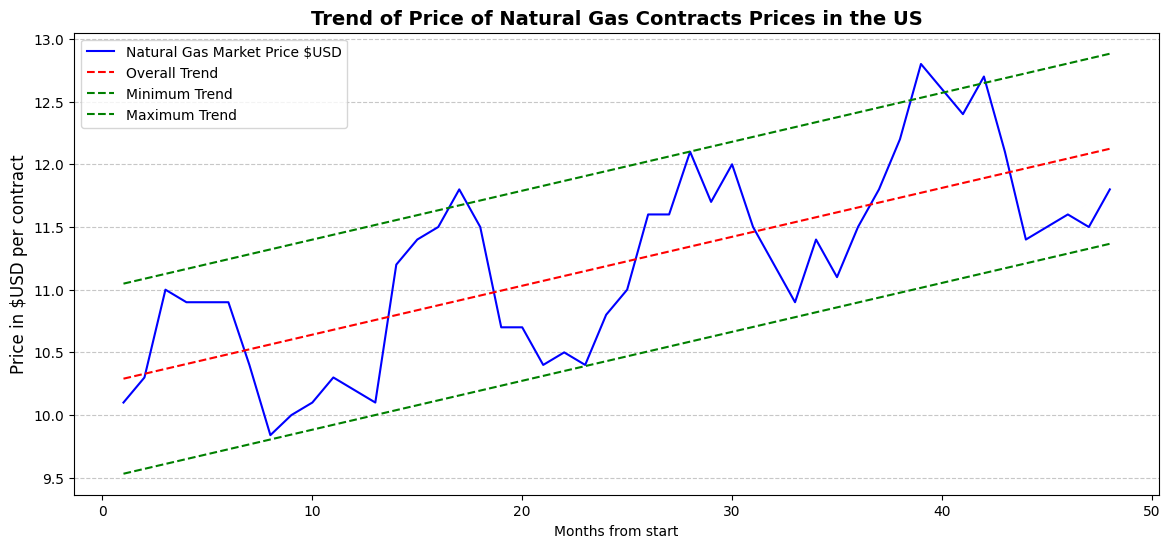

In [11]:
# General trend and standart deviation of the prices
trend = np.polyval(reg, data['time'])
std = data['Prices'].std()
plt.figure(figsize=(14, 6))
plt.plot(data['time'].values, data['Prices'].values, color='blue', label='Natural Gas Market Price $USD')
plt.plot(data['time'].values, trend, 'r--', label='Overall Trend')
plt.plot(data['time'].values, trend - std, 'g--', label='Minimum Trend')
plt.plot(data['time'].values, trend + std, 'g--', label='Maximum Trend')
plt.xlabel('Months from start')
plt.ylabel('Price in $USD per contract', fontsize=12)
plt.title('Trend of Price of Natural Gas Contracts Prices in the US', fontsize=14, weight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
# Determining seasonality in prices
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(gas_df['Prices'], model='multiplicative', period=12)

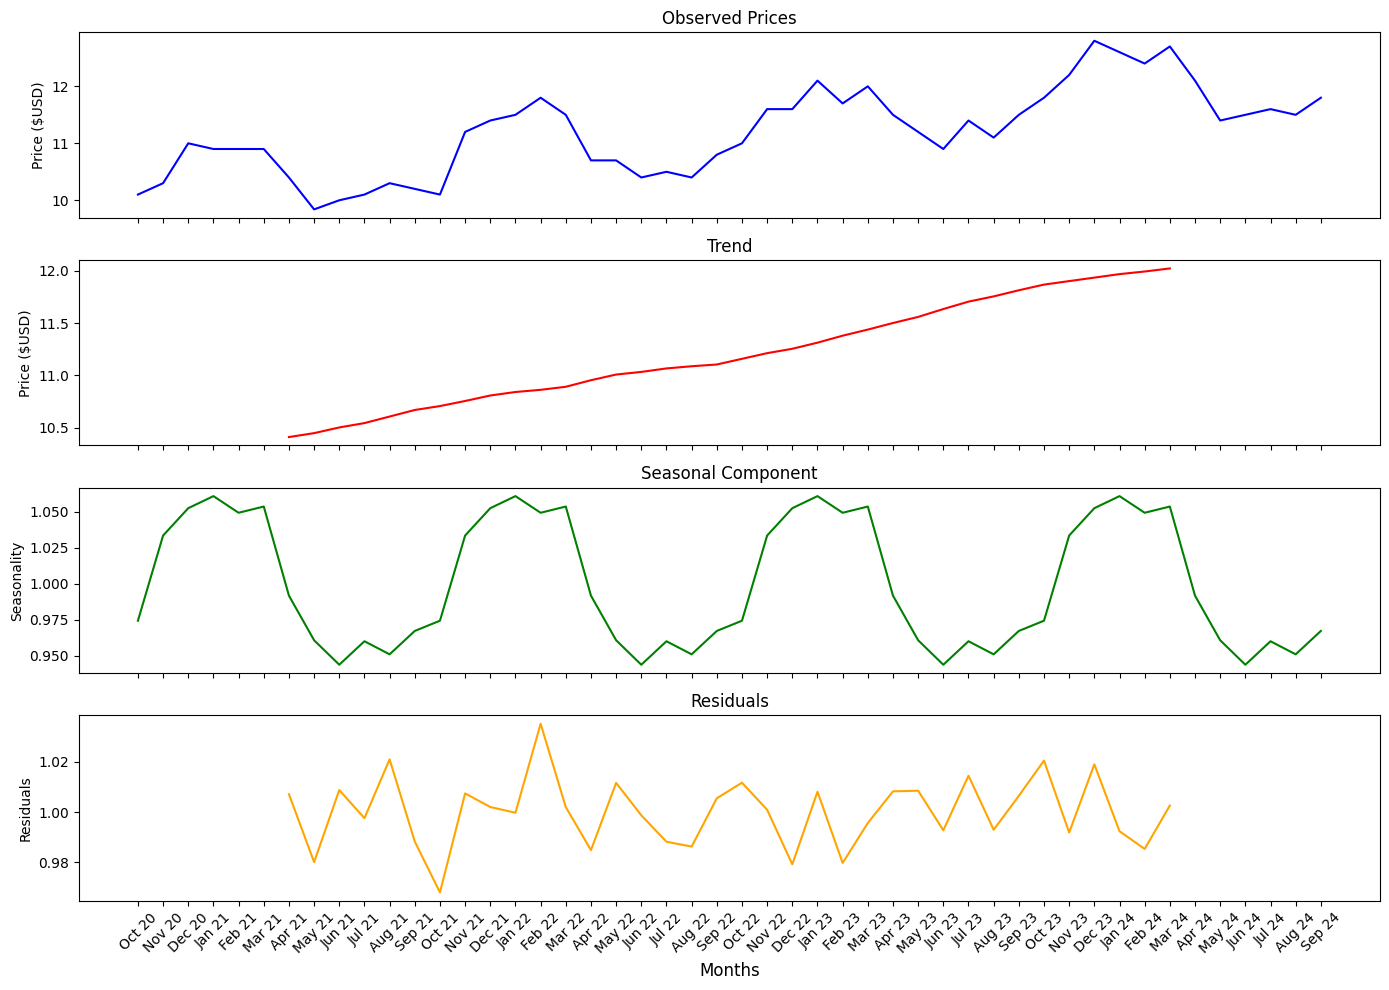

In [13]:
# Plotting trends and seasonality in gas prices
def plotting_seasonal_decompose():
    # Create figure
    fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

    # Observed data
    axs[0].plot(result.observed, color='blue')
    axs[0].set_title('Observed Prices', fontsize=12)
    axs[0].set_ylabel('Price ($USD)')

    # Trend
    axs[1].plot(result.trend, color='red')
    axs[1].set_title('Trend', fontsize=12)
    axs[1].set_ylabel('Price ($USD)')

    # Seasonal component
    axs[2].plot(result.seasonal, color='green')
    axs[2].set_title('Seasonal Component', fontsize=12)
    axs[2].set_ylabel('Seasonality')

    # Residuals
    axs[3].plot(result.resid, color='orange')
    axs[3].set_title('Residuals', fontsize=12)
    axs[3].set_ylabel('Residuals')

    # Set x-axis ticks and labels
    plt.xticks(ticks=np.arange(len(str_months)), labels=str_months, rotation=45, fontsize=10)
    axs[3].set_xlabel('Months', fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

plotting_seasonal_decompose()

### 3. Forecasting using ARIMA model ###

In [14]:
# Reseting the DataFrame
gas_df = pd.read_csv('natural_gas_market_data.csv')
gas_df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
# Converting month into datetime format
gas_df['Dates'] = pd.to_datetime(gas_df['Dates'])
# Setting dates as index
gas_df.set_index('Dates', inplace=True)
gas_df.head()


/var/folders/0v/nd2019hd3lxb6r07g9ywbv500000gn/T/ipykernel_93909/1215251801.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gas_df['Dates'] = pd.to_datetime(gas_df['Dates'])


,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


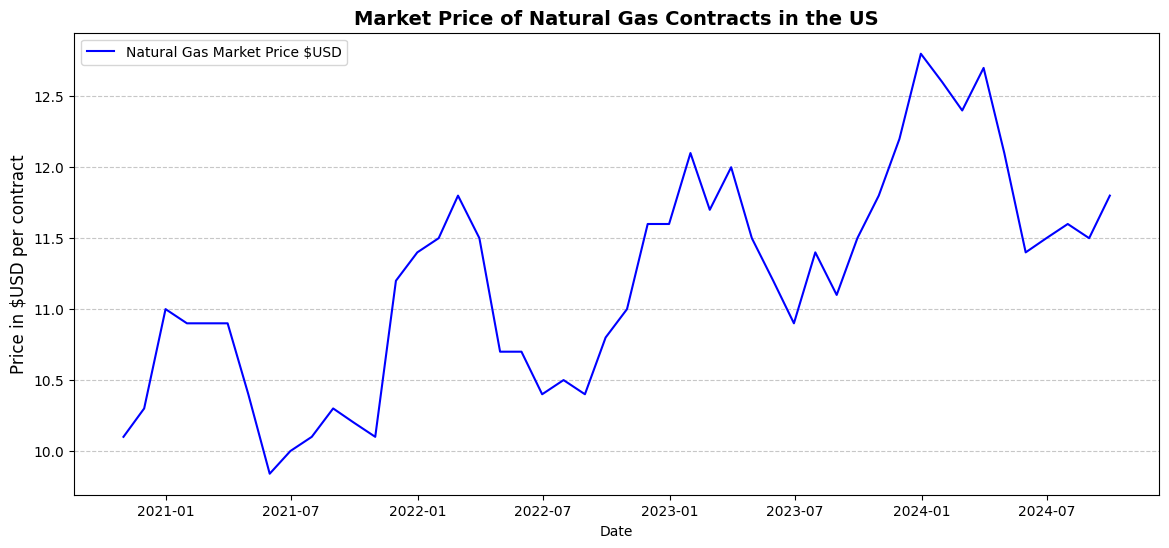

In [17]:
# Visualization of the market price of gas storage contracts
plt.figure(figsize=(14, 6))
plt.plot(gas_df.index, gas_df['Prices'], color='blue', label='Natural Gas Market Price $USD')
plt.xlabel('Date')
plt.ylabel('Price in $USD per contract', fontsize=12)
plt.title('Market Price of Natural Gas Contracts in the US', fontsize=14, weight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
# Testing stationarity of the data
from statsmodels.tsa.stattools import adfuller

In [19]:
test_result = adfuller(gas_df['Prices'])
test_result

(0.2180768616999943,
 0.973257438844869,
 10,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 10.198475035166396)

In [20]:
#Ho: The time serie is non stationary
#H1: The time serie is stationary

def adfuller_test(Prices):
    result=adfuller(Prices)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(gas_df['Prices'])

ADF Test Statistic : 0.2180768616999943
p-value : 0.973257438844869
#Lags Used : 10
Number of Observations Used : 37
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [21]:
# Model fitting on the data using arima model
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Running auto arima model to get the best p,d,q,P,D,Q values
pm.auto_arima(gas_df['Prices'], seasonal=True, m=12,
              max_p=7, max_d=5, max_q=7,
              max_P=4, max_D=4, max_Q=4,
              trace=True, error_action='ignore',
              supress_warning=True, stepwise=True).summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=37.653, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=38.742, Time=0.56 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=38.341, Time=0.62 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=36.045, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.02 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=53.674, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=51.953, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -12.022
Date:                Wed, 22 Jan 2025   AIC                             36.045
Time:                        21:38:20   BIC                             47.145
Sample:                    10-31-2020   HQIC                            40.222
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0100      0.008      1.286      0.199      -0.005       0.025
ar.L1          1.6991      0.050     33.849      0.000       1.601       1.798
ar.L2         -0.9610      0.048    -19.842      0.000      -1.056      -0.866
ma.L1         -1.8072      0.344     -5.261      0.000      -2.480      -1.134
ma.L2          0.9590      0.382      2.509      0.012       0.210       1.708
sigma2         0.0872      0.032      2.682      0.007       0.023       0.151
===================================================================================
Ljung-Box (L1) (Q):                   6.41   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.01   Prob(JB):                         0.33
Heteroskedasticity (H):               0.85   Skew:                             0.50
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# Splitting the data into training and testing sets
train_data = gas_df[:len(gas_df)-12]
test_data = gas_df[len(gas_df)-12:]

In [23]:
# Compiling the model and saving it
arima_model = SARIMAX(train_data['Prices'], order=(2,1,2), seasonal_order=(1,1,1,12))
arima_result = arima_model.fit()
arima_result.summary()

/Users/thibaultmarty/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/thibaultmarty/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/thibaultmarty/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63074D-01    |proj g|=  1.65386D-01

At iterate    5    f=  7.81620D-02    |proj g|=  1.75871D-01

At iterate   10    f=  4.61098D-02    |proj g|=  1.34652D-01

At iterate   15    f=  4.24090D-02    |proj g|=  5.41430D-02

At iterate   20    f=  1.52570D-02    |proj g|=  2.31647D-01

At iterate   25    f=  2.03654D-03    |proj g|=  6.46259D-02

At iterate   30    f= -3.65749D-03    |proj g|=  2.00373D-02

At iterate   35    f= -4.49468D-03    |proj g|=  6.66961D-02

At iterate   40    f= -4.59249D-03    |proj g|=  7.43199D-03

At iterate   45    f= -4.59397D-03    |proj g|=  3.21794D-03

At iterate   50    f= -4.59412D-03    |proj g|=  6.31825D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/thibaultmarty/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Prices   No. Observations:                   36
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                   0.165
Date:                              Wed, 22 Jan 2025   AIC                             13.669
Time:                                      21:38:20   BIC                             21.618
Sample:                                  10-31-2020   HQIC                            15.668
                                       - 09-30-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0930     67.525     -0.016      0.987    -133.439     131.253
ar.L2         -0.0936      6.477     -0.014      0.988     -12.788      12.601
ma.L1         -0.2572    743.941     -0.000      1.000   -1458.354    1457.840
ma.L2         -0.7427    552.543     -0.001      0.999   -1083.707    1082.222
ar.S.L12      -0.6463      0.790     -0.818      0.413      -2.195       0.903
ma.S.L12      -0.9958    945.053     -0.001      0.999   -1853.265    1851.274
sigma2         0.0155     18.079      0.001      0.999     -35.418      35.449
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.84   Prob(JB):                         0.82
Heteroskedasticity (H):               0.92   Skew:                            -0.22
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
arima_pred  = arima_result.predict(start=len(train_data), end=len(gas_df)-1, typ='levels').rename('ARIMA Predictions')
print(arima_pred)

2023-10-31    11.122605
2023-11-30    12.294417
2023-12-31    12.406844
2024-01-31    12.668921
2024-02-29    12.660913
2024-03-31    12.667084
2024-04-30    11.677799
2024-05-31    11.728383
2024-06-30    11.412404
2024-07-31    11.636825
2024-08-31    11.530337
2024-09-30    11.862753
Freq: ME, Name: ARIMA Predictions, dtype: float64


/Users/thibaultmarty/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


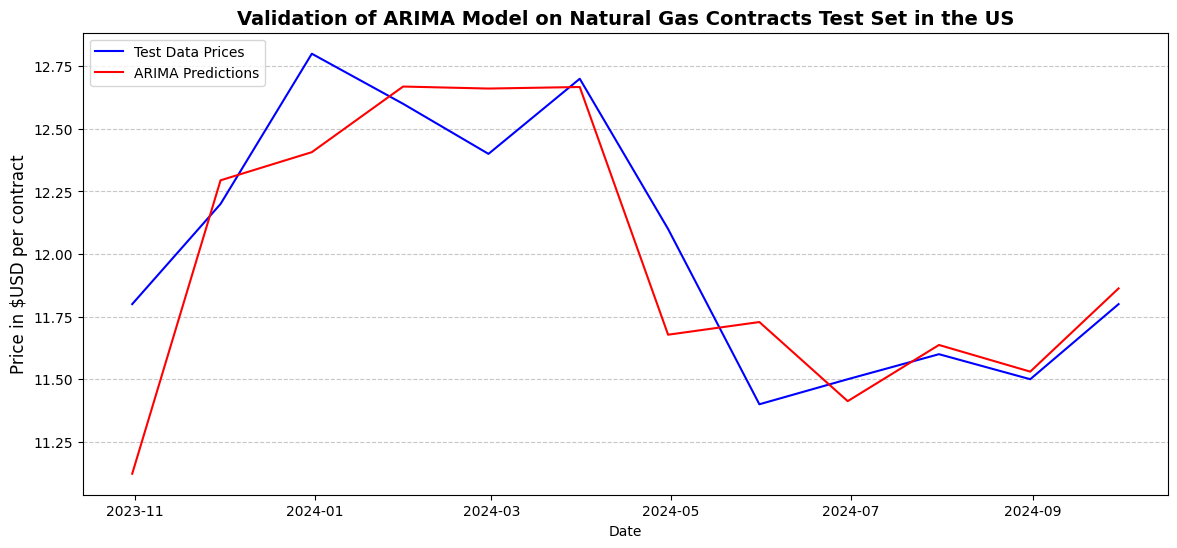

In [25]:
# Validation of the prediction over test set
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['Prices'], color='blue', label='Test Data Prices')
plt.plot(arima_pred.index, arima_pred.values, color='red', label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Price in $USD per contract', fontsize=12)
plt.title('Validation of ARIMA Model on Natural Gas Contracts Test Set in the US', fontsize=14, weight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

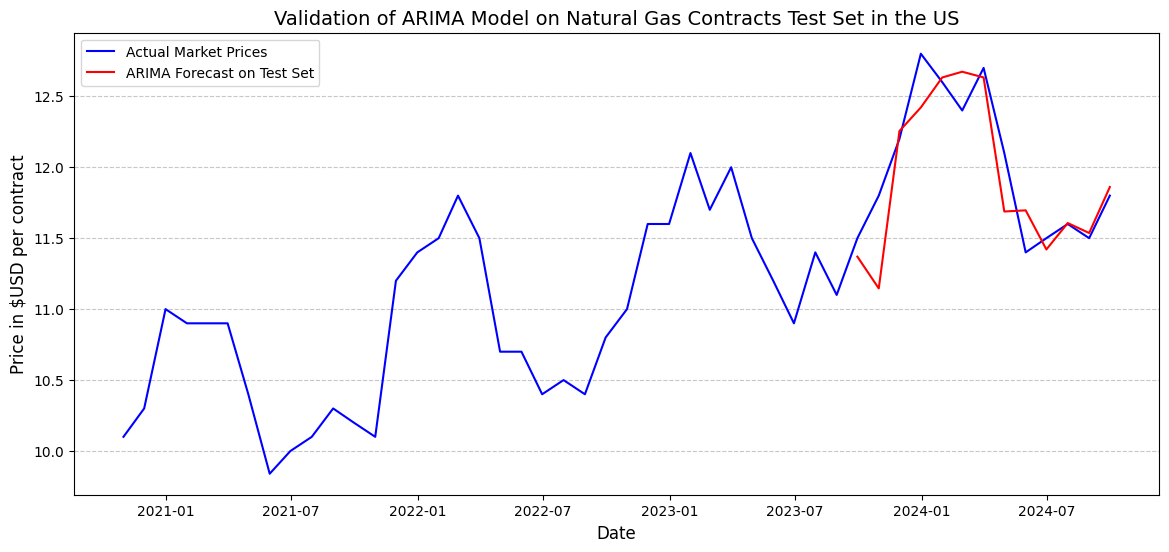

,Prices,forecast
Dates,,
2024-05-31,11.4,11.696165
2024-06-30,11.5,11.420534
2024-07-31,11.6,11.606678
2024-08-31,11.5,11.536370
2024-09-30,11.8,11.860320


In [26]:
gas_df['forecast'] = arima_result.predict(start=35, end=47, dynamic=True)

# Validation of the prediction over the test set
plt.figure(figsize=(14, 6))
# Plot actual prices
plt.plot(gas_df.index, gas_df['Prices'], color='blue', label='Actual Market Prices')
# Plot forecast
plt.plot(gas_df.index, gas_df['forecast'], color='red', label='ARIMA Forecast on Test Set')
# Adding labels, title, and legend
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in $USD per contract', fontsize=12)
plt.title('Validation of ARIMA Model on Natural Gas Contracts Test Set in the US', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
# Adding grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show the plot
plt.show()

gas_df.tail()

In [27]:
test_data = test_data.copy()
test_data.loc[:, 'ARIMA_Predictions'] = arima_pred
test_data

,Prices,ARIMA_Predictions
Dates,,
2023-10-31,11.8,11.122605
2023-11-30,12.2,12.294417
2023-12-31,12.8,12.406844
2024-01-31,12.6,12.668921
2024-02-29,12.4,12.660913
2024-03-31,12.7,12.667084
2024-04-30,12.1,11.677799
2024-05-31,11.4,11.728383
2024-06-30,11.5,11.412404


In [38]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data.Prices, test_data.ARIMA_Predictions)
arima_mse_error = mean_squared_error(test_data.Prices, test_data.ARIMA_Predictions)
gas_mean_price = gas_df.Prices.mean()

print(f'MSE Error: {round(arima_mse_error, 2)}$^2\nRMSE Error: {round(arima_rmse_error, 2)}$\nMean: {round(gas_mean_price, 2)}$')
print(f'Percentage of error: {round(arima_rmse_error/gas_mean_price*100, 2)}%')

MSE Error: 0.08$^2
RMSE Error: 0.29$
Mean: 11.21$
Percentage of error: 2.57%


### Running the code with entered date ###

In [29]:
arima_pred_12m = arima_result.predict(start=len(gas_df), end=len(gas_df)+12, type='levels').rename('ARIMA Predictions')
print(arima_pred_12m)

2024-10-31    11.918109
2024-11-30    12.713459
2024-12-31    12.755183
2025-01-31    13.169536
2025-02-28    12.909631
2025-03-31    13.104260
2025-04-30    12.432650
2025-05-31    12.255204
2025-06-30    11.950996
2025-07-31    12.352083
2025-08-31    12.121968
2025-09-30    12.496624
2025-10-31    12.273729
Freq: ME, Name: ARIMA Predictions, dtype: float64


/Users/thibaultmarty/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [30]:
# Convert `arima_pred_12m` (Series) to DataFrame
arima_pred_12m = arima_pred_12m.to_frame(name='forecast')

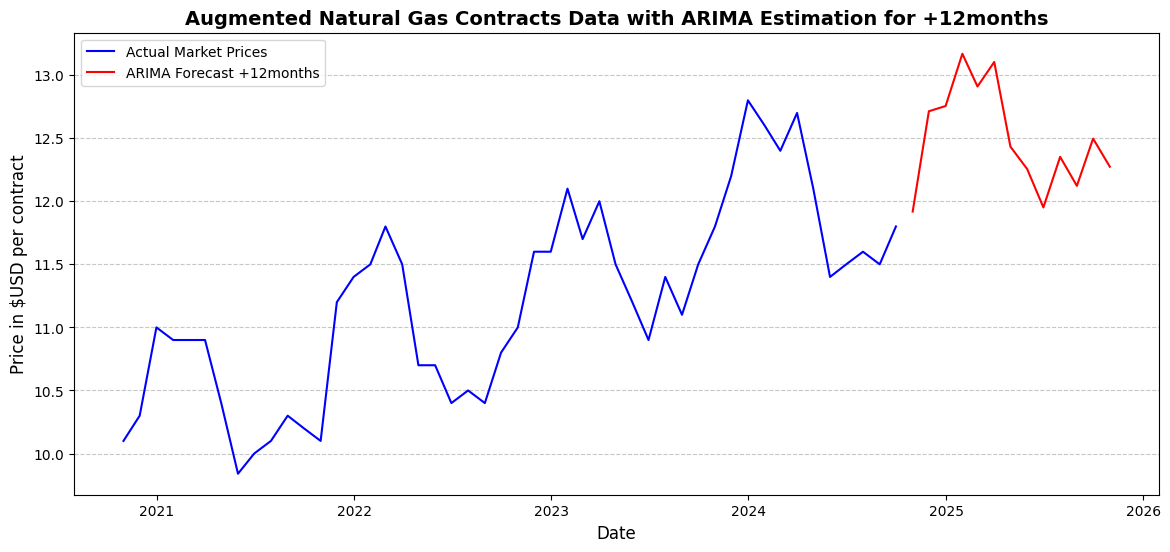

In [36]:
# Reindex `arima_pred_12m` to align with `gas_df`
forecast_df = pd.DataFrame(index=arima_pred_12m.index)
forecast_df['forecast'] = arima_pred_12m['forecast']
forecast_df['Prices'] = float('NaN')  # Fill Prices with NaN

# Concatenate the two DataFrames
gas_df_combined = pd.concat([gas_df, forecast_df])

# Plot the combined DataFrame
plt.figure(figsize=(14, 6))

# Plot known prices (historical data)
plt.plot(gas_df_combined.index, gas_df_combined['Prices'], color='blue', label='Actual Market Prices')

# Plot forecasted prices (future predictions)
plt.plot(forecast_df.index, forecast_df['forecast'], color='red', label='ARIMA Forecast +12months')

# Adding labels, title, and legend
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in $USD per contract', fontsize=12)
plt.title('Augmented Natural Gas Contracts Data with ARIMA Estimation for +12months', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)

# Adding grid for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [32]:
from datetime import datetime

while True:
    try:
        # User input
        userdate = input("Enter the date of the last day of the month (YYYY-MM-DD), or 'x' to exit: ")
        
        if userdate.lower() == 'x':  # Exit condition
            break
        
        # Convert user input to datetime
        userdate = datetime.strptime(userdate, '%Y-%m-%d')

        # Validate if the entered date is within the DataFrame index range
        if userdate > gas_df_combined.index[-1]:
            print('The date is greater than the +12 months prediction. Please try again.')
        elif userdate < gas_df_combined.index[0]:
            print('The date is lower than the first date in the dataset. Please try again.')
        else:
            # Check if the date is within the historical range
            if userdate <= datetime(2024, 10, 31):  # Replace with the exact cut-off date
                print(f"Quote for {userdate.strftime('%Y-%m-%d')} was set at: {gas_df_combined.loc[userdate, 'Prices']}$")
            else:
                print(f"Quote for {userdate.strftime('%Y-%m-%d')} is forecasted to be at: {round(gas_df_combined.loc[userdate, 'forecast'], 2)}$")
    except ValueError:
        print('The date entered is not valid. Please enter a valid date in the format YYYY-MM-DD.')
    except KeyError:
        print('The entered date is not found in the dataset. Please try another date.')
